# Dataset creation

We were given the dataset as already split in the train, test and validation set, so we had to reassemble it to the operation needed for our project

<h4>Test Set</h4>

In [ ]:
import pandas as pd
test = pd.read_csv("dataset/original/full_test.csv")


display(test.head(5))
test.info()
test["account.type"].value_counts()


<h4>Train Set</h4>

In [ ]:
train = pd.read_csv("dataset/original/full_train.csv")

display(train.head(5))
train.info()
train["account.type"].value_counts()

<h4>Validation Set</h4>

In [ ]:
val = pd.read_csv("dataset/original/full_validation.csv")


display(val.head(5))
val.info()
val["account.type"].value_counts()

Since the tables had the same number and types of column we just concateneted them to create a whole dataset which we proceeded to preprocess.

In [ ]:
df = pd.concat([train,val])
dataset = pd.concat([df,test])
dataset = dataset.reset_index()    #without this operation indexes will be duplicated
dataset.to_csv("dataset/full_dataset.csv")


display(dataset.head(5))
dataset.info()
dataset["account.type"].value_counts()


In [5]:
dataset.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
index,25572.0,NaN,NaN,NaN,8618.878852,6473.347882,0.0,2130.75,7925.5,14318.25,20711.0
user_id,25572,41,979586167405363200,2409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
status_id,25572,25567,1280232979781111808,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen_name,25572,40,kevinhooke,2409,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,25572,25570,“Dis Dat Mosh Talk” <U+0001F92C>,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
account.type,25572,2,bot,12786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class_type,25572,4,human,12786,NaN,NaN,NaN,NaN,NaN,NaN,NaN
screen_name_anonymized,25572,40,human#10,2409,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='account.type', ylabel='count'>

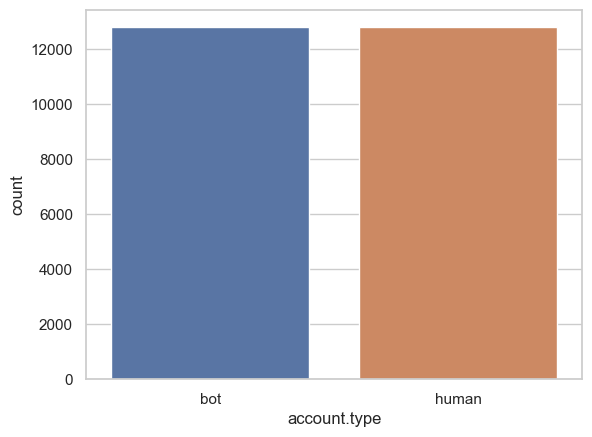

In [6]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=dataset["account.type"])

The dataset is balanced

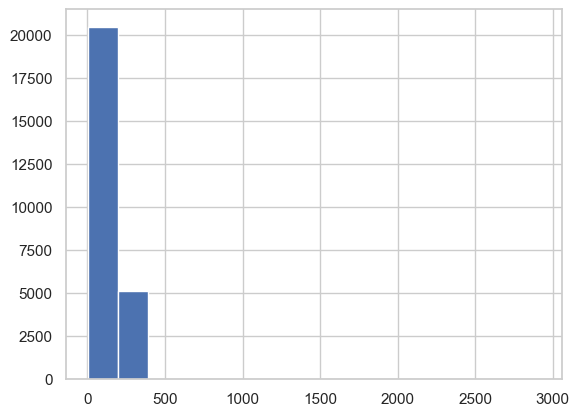

In [7]:
from matplotlib import pyplot as plt
plt.hist([len(x) for x in dataset['text']],bins = 15)
plt.show()

As we can see in the graph above around 4/5 of Tweet have less than 250 charachters, the other ones have betweetn 250 and 500 charcters.

### Some considerations over the Dataset

First of all we don't have an even number of bots and human accounts, that's because some fake accounts imitate the same human profile so in the end as we can see we have we obtained 23 bots and 17 human accounts. <br>
Anyway, to reach our goal it's important having balanced values for the attribute "account.type"

In [8]:
import string

print("Bots Count")
bots = dataset.loc[ dataset['screen_name_anonymized'].str.startswith("bot") == True ]
print(len(pd.unique(bots["screen_name_anonymized"])))


print("Humans Count")
humans = dataset.loc[ dataset['screen_name_anonymized'].str.startswith("human") == True ]
print(len(pd.unique(humans["screen_name_anonymized"])))


Bots Count
23
Humans Count
17


We also have some duplicate Tweet in the database.<br>
We have two different situation: 
<ol>
    <li> We have discrepancy of unique text count and the unique status_id count. It means that we have different Tweets with the same id, but it is impossible. </li>
    <li> We have discrepancy between the number of unique text and the size of dataset. We have to check if this situation is due to the duplicated id or for other reasons.</li>
</ol>

<h4>First case: Duplicated Status Ids</h4>

As we could see in the analysis of the dataset some status id were identical and related to the same user 

In [ ]:
mask = dataset["status_id"].duplicated(keep=False)
print(dataset.loc[mask][["status_id", "text", "screen_name_anonymized"]])

#the output was cleaned due to privacy reasons

While examinating the duplicate Tweets we also noticed that some UTF8 Characters weren't memorized correctly in the dataset, that lead in the further evolving of the analysis to having in our dictionary some "wrong" words and to the loss of the correct words. Moreover this influnce also the count of the tokens in the process of "feature selection". 
For example many tweets contained vulgar words masked with some special carachters that were lost or the apex. 

So before proceeding with further operation we searched wrong characters and noticed that they were all ', hence we replaced them all to restore the correct meaning of the phrases.

## Data cleaning

In [10]:
vector = []

for i in range(0, len(dataset)): 
    if "ï¿½" in dataset.loc[i]["text"]:
        vector.append(dataset.loc[i]["text"].replace("ï¿½", "'"))
    elif "Ã¯Â¿Â½" in dataset.loc[i]["text"]:
        vector.append(dataset.loc[i]["text"].replace("Ã¯Â¿Â½", "'"))
    else:
        vector.append(dataset.loc[i]["text"])
        
    

dataset["text"] = vector

dataset.to_csv("dataset/fixed.csv")

# check if something gone wrong

for i in range(0, len(dataset)): 
    if "ï¿½" in dataset.loc[i]["text"] or "Ã¯Â¿Â½" in dataset.loc[i]["text"]:
        print(dataset.loc[i]["text"])

We can now remove duplicated tweets

In [ ]:
mask = dataset["status_id"].duplicated(keep=False)
print(dataset.loc[mask][["status_id", "text", "screen_name_anonymized"]])
dataset["account.type"].value_counts()
#the output was cleaned due to privacy reasons

In [12]:
temp = dataset.drop_duplicates(subset=['status_id', 'screen_name_anonymized'], keep="last")

mask = temp["status_id"].duplicated(keep=False)
print(temp.loc[mask][["status_id", "text", "screen_name_anonymized"]])

temp.to_csv("dataset/fixed.csv")
temp["account.type"].value_counts()

Empty DataFrame
Columns: [status_id, text, screen_name_anonymized]
Index: []


bot      12786
human    12781
Name: account.type, dtype: int64

This made necessary for us to delete the duplicates records, keeping only one copies of the duplicates.


### Second case: Duplicated Tweets


In [ ]:
dataset=pd.read_csv("dataset/fixed.csv")

mask = dataset["text"].duplicated(keep=False)
print(dataset.loc[mask][["text", "screen_name_anonymized"]])
#the output was cleaned due to privacy reasons

In this case instead the tweet content was perfectly identical, but they are not the same tweet since the status_id and the user who wrote them are different!

In [14]:
update_df = dataset.drop([7174,15692,21316,25156], axis=0)
update_df.to_csv("dataset/fixed.csv")

In [15]:
mask = update_df["text"].duplicated(keep=False)
print(update_df.loc[mask][["text", "screen_name_anonymized"]])

update_df["account.type"].value_counts()

Empty DataFrame
Columns: [text, screen_name_anonymized]
Index: []


bot      12784
human    12779
Name: account.type, dtype: int64

# Data pre-processing

<p>As a first step in the preprocessing phase we simply rename the column as needed and divide the dataset columns into tweets and ids </p>

In [16]:
update_df.rename(columns = {'text':'Tweet', 'account.type':'Account_type'}, inplace = True)
tweet = update_df[["Tweet","Account_type"]]

## "Feature selection": tuning

We want to discover if the Tweets text have to be mantained as they are or if they need to be modified. <br>
How can we handle...
<ul>
    <li> ...tag? </li>
    <li> ...url? </li>
    <li> ...hastag? </li>
</ul>

As parameters for our choice we evaluated firstly accuracy and then in case of equal accuracy performances we considered dataset dimension.

In [17]:
from sklearn.model_selection import train_test_split
# @tag
tweet_no_mention = tweet.copy()
pd.options.mode.chained_assignment = None  # default='warn'
def removeUserMention(string):
    if string.startswith('@'):
        return "__user_mention__"
    return string

def cleanMentions(tweet):
    tokens = tweet.split()
    tokens = [removeUserMention(elem) for elem in tokens]  
    return ' '.join([str(elem) for elem in tokens])

tweet_no_mention['Tweet'] = tweet_no_mention['Tweet'].apply(cleanMentions)

complete_train, complete_test, complete_class_train, complete_class_test = train_test_split(tweet.Tweet,tweet.Account_type, random_state=0, test_size=0.2)
no_mention_train, no_mention_test, no_mention_class_train, no_mention_class_test = train_test_split(tweet_no_mention.Tweet,tweet_no_mention.Account_type, random_state=0, test_size=0.2)

In [18]:
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.model_selection import cross_val_score
def custom_accuracy_validation(pipeline, skf, X, y):
    list_accuracy = []

    for train, val in skf.split(X, y):
        # fit and predict using pipeline
        X_tr = X[train]
        y_tr = y[train]
        X_val = X[val]
        y_val = y[val]
        pipeline.fit(X_tr,y_tr)
        y_pred = pipeline.predict(X_val)
        # compute classification report
        cr = classification_report(y_val,y_pred,output_dict = True)
        # store accuracy
        list_accuracy.append(cr['accuracy'])
    return list_accuracy

## Should we keep the mentions or we should replace it with __user_mention__ ?

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


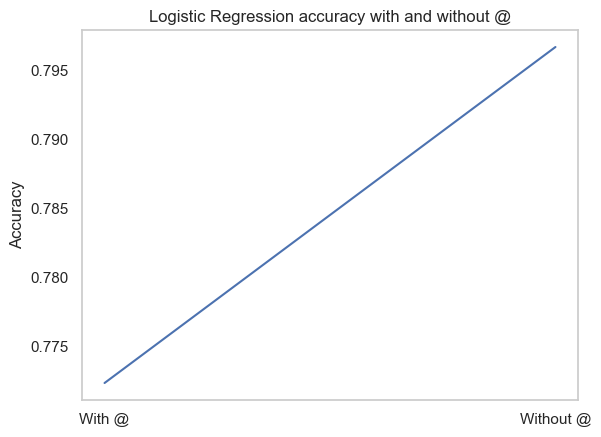

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import nltk 

nltk.download('stopwords')
nltk.download('words')
stopwords = set(nltk.corpus.stopwords.words('english'))

pipeline=Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),('clf', LogisticRegression())])

results_list=[]

#with @tag

results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

#without @tag
results=cross_val_score(pipeline, no_mention_train.to_numpy(),no_mention_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

x=["With @","Without @"]
plt.plot(x, results_list)
plt.ylabel("Accuracy")
plt.title("Logistic Regression accuracy with and without @")
plt.grid()

We take the dataset without the mentions, since the differencies in accuracy is about 3%

## Should we keep the url or we should replace it with __url__ ?

In [20]:
tweet_no_url = tweet_no_mention.copy()

def removeUrl(string):
    if string.startswith('http'):
        return "__url__"
    return string

def cleanUrls(tweet):
    tokens = tweet.split()
    tokens = [removeUrl(elem) for elem in tokens]  
    return ' '.join([str(elem) for elem in tokens])

tweet_no_url['Tweet'] = tweet_no_url['Tweet'].apply(cleanUrls)

no_url_train, no_url_test, no_url_class_train, no_url_class_test = train_test_split(tweet_no_url.Tweet,tweet_no_url.Account_type, random_state=0, test_size=0.2)


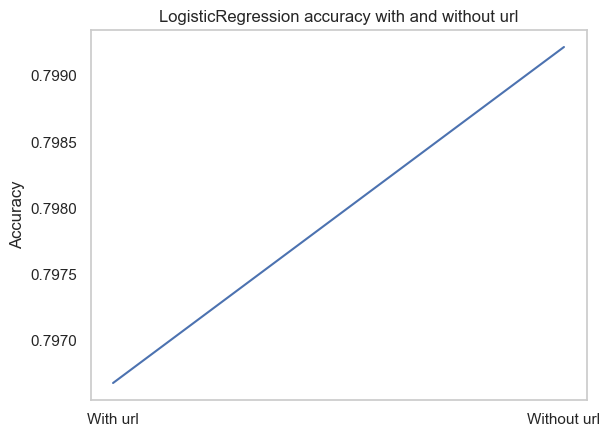

In [21]:
results_list=[]

#with url
results=cross_val_score(pipeline, no_mention_train.to_numpy(),no_mention_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))


#without url
results=cross_val_score(pipeline, no_url_train.to_numpy(),no_url_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

x=["With url","Without url"]
plt.plot(x, results_list)
plt.ylabel("Accuracy")
plt.title("LogisticRegression accuracy with and without url")
plt.grid()

In [22]:
from scipy.stats import wilcoxon
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
accuracies_no_urls = custom_accuracy_validation(pipeline, skf,no_url_train.to_numpy(),no_url_class_train.to_numpy())

accuracies_urls = custom_accuracy_validation(pipeline, skf,no_mention_train.to_numpy(),no_mention_class_train.to_numpy())
wilcoxon(accuracies_no_urls, accuracies_urls)  #α = 0.05

C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.01151382807684542)

Given the confidence level α=0.05, we can conclude that as *p*-value < α, the null hypothesis (that the two related paired samples come from the same distribution) can be rejected.

We can conclude that there is significant difference between the two classification pipelines in terms of the chosen classification metric (accuracy).

The classification pipeline without urls can be regarded as the most suitable one.

## How should we handle hashtags?

Here too we have 3 possibilities:

-   __“#twitter" —> “twitter”__
    <br> sostituisco con il contenuto; mantengo il contenuto dell’hashtag, ma perdo l’informazione che si trattava di un hashtag


- **“#twitter" —> “\_\_hashtag\_\_”**<br>sostituisco con un token speciale; mantengo l’informazione che si trattava di un hashtag, ma ne perdo il contenuto


-   **“#twitter" —> “\_\_hashtag\_\_ twitter”** <br>sostituisco con un token speciale e riporto anche il contenuto, così mantengo entrambe.



In [23]:
def removeHastag(string):
    if string.startswith('#'):
        return "__hastag__"
    return string

def hastagAndText(string):
    if string.startswith('#'):
        return "__hastag__ "+string
    return string

def hastagOnlyText(string):
    if string.startswith('#'):
        return string[1:]
    return string 

def hastag_and_text(tweet):
    tokens = tweet.split()
    tokens = [hastagAndText(elem) for elem in tokens]  
    return ' '.join([str(elem) for elem in tokens])

def hastag_only_text(tweet):
    tokens = tweet.split()
    tokens = [hastagOnlyText(elem) for elem in tokens]  
    return ' '.join([str(elem) for elem in tokens])

def no_hastag(tweet):
    tokens = tweet.split()
    tokens = [removeHastag(elem) for elem in tokens]  
    return ' '.join([str(elem) for elem in tokens])


tweet_no_hastag = tweet_no_url.copy()
tweet_no_hastag['Tweet'] = tweet_no_hastag['Tweet'].apply(no_hastag)
no_hastag_train, no_hastag_test, no_hastag_class_train, no_hastag_class_test = train_test_split(tweet_no_hastag.Tweet,tweet_no_hastag.Account_type, random_state=0, test_size=0.2)


tweet_hastag_and_text = tweet_no_url.copy()
tweet_hastag_and_text['Tweet'] = tweet_hastag_and_text['Tweet'].apply(hastag_and_text)
hastag_and_text_train, hastag_and_text_test, hastag_and_text_class_train, hastag_and_text_class_test = train_test_split(tweet_hastag_and_text.Tweet,tweet_hastag_and_text.Account_type, random_state=0, test_size=0.2)


tweet_hastag_text = tweet_no_url.copy()
tweet_hastag_text['Tweet'] = tweet_hastag_text['Tweet'].apply(hastag_only_text)
only_text_train, only_text_test, only_text_class_train, only_text_class_test = train_test_split(tweet_hastag_text.Tweet,tweet_hastag_text.Account_type, random_state=0, test_size=0.2)


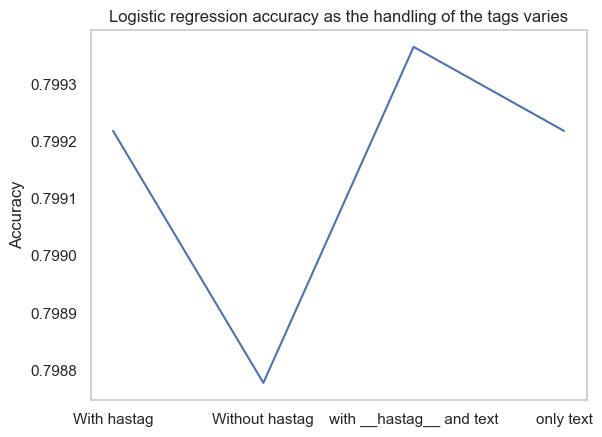

In [24]:
results_list=[]

#with hastag
results=cross_val_score(pipeline, no_url_train.to_numpy(),no_url_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

#without hastag
results=cross_val_score(pipeline, no_hastag_train.to_numpy(),no_hastag_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

#with hastag and text
results=cross_val_score(pipeline, hastag_and_text_train.to_numpy(),hastag_and_text_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

#without hastag but only with the text
results=cross_val_score(pipeline, only_text_train.to_numpy(),only_text_class_train.to_numpy(), 
                        cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

x=["With hastag","Without hastag", "with __hastag__ and text", "only text"]
plt.plot(x, results_list)
plt.ylabel("Accuracy")
plt.title("Logistic regression accuracy as the handling of the tags varies")
plt.grid()

In [25]:
accuracies_hastag = custom_accuracy_validation(pipeline, skf,no_url_train.to_numpy(),no_url_class_train.to_numpy())
accuracies_no_hastag = custom_accuracy_validation(pipeline, skf,no_hastag_train.to_numpy(),no_hastag_class_train.to_numpy())

print("No hastag")
print(wilcoxon(accuracies_no_hastag, accuracies_hastag))  #α = 0.05

accuracies_hastag_and_text = custom_accuracy_validation(pipeline, skf,hastag_and_text_train.to_numpy(),hastag_and_text_class_train.to_numpy())
print("Hastag and text")
print(wilcoxon(accuracies_hastag_and_text, accuracies_hastag))  #α = 0.05

accuracies_text = custom_accuracy_validation(pipeline, skf,only_text_train.to_numpy(),only_text_class_train.to_numpy())
print("Only text")
try:
    print(wilcoxon(accuracies_text, accuracies_hastag))  #α = 0.05
except:
    print("Equal distribution")

No hastag
WilcoxonResult(statistic=4.5, pvalue=0.013671875)
Hastag and text
WilcoxonResult(statistic=16.0, pvalue=0.4314014169471778)


C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


Only text
Equal distribution


C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [28]:
X_train_vector = pipeline['tfidf'].fit_transform(complete_train)
X_train_vector.shape

(20450, 27482)

Since there are no differences between using the dataset with original hastag and using the dataset using the token \_\_hastag\_\_, we would use the original dataset, since, in the last phase of our work, it will implicate one less pre-processing step

**We keep the  dataset with original #hastag**

In [27]:
final_dataset = tweet_no_url
complete_train, complete_test, complete_class_train, complete_class_test = train_test_split(final_dataset.Tweet,final_dataset.Account_type, random_state=55, test_size=0.2)

## max_df and min_df parameter tuning

In [24]:
results_list=[]

for min_df in np.arange(0.0,0.0025,0.0002):
    pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df = min_df)),
        ('clf', LogisticRegression())
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

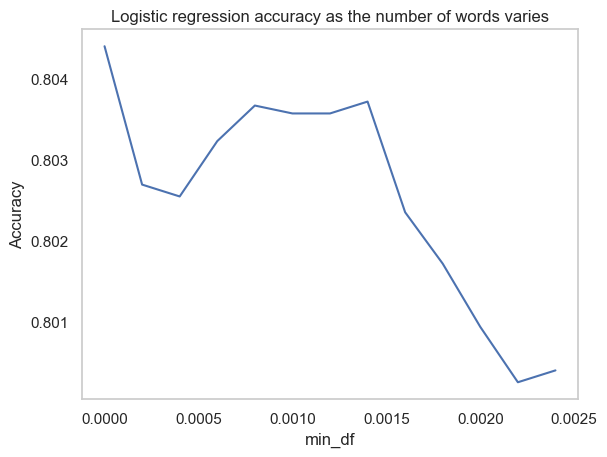

In [25]:
x=np.arange(0.0,0.0025,0.0002)
plt.plot(x, results_list)
plt.xlabel("min_df")
plt.ylabel("Accuracy")
plt.title("Logistic regression accuracy as the number of words varies")
plt.grid()

In [26]:
pipeline_0=Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df = 0.0)),
    ('clf', LogisticRegression())
])
accuracies_0 = custom_accuracy_validation(pipeline_0, skf,complete_train.to_numpy(),complete_class_train.to_numpy())

pipeline_0004=Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df = 0.0004)),
    ('clf', LogisticRegression())
])
accuracies_0004 = custom_accuracy_validation(pipeline_0004, skf,complete_train.to_numpy(),complete_class_train.to_numpy())

print(wilcoxon(accuracies_0, accuracies_0004))  #α = 0.05

WilcoxonResult(statistic=21.0, pvalue=0.556640625)


Given the confidence level α=0.05, we can conclude that as *p*-value > α, the null hypothesis (that the two related paired samples come from the same distribution) cannot be rejected.

We can conclude that there is not significant difference between the two classification pipelines in terms of the chosen classification metric (accuracy).

The classification pipeline with min_df = 0.0004 can be regarded as the most suitable one.

In [27]:
pipeline_0=Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df = 0.0012)),
    ('clf', LogisticRegression())
])
accuracies_0 = custom_accuracy_validation(pipeline_0, skf,complete_train.to_numpy(),complete_class_train.to_numpy())

pipeline_0004=Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, min_df = 0.0004)),
    ('clf', LogisticRegression())
])
accuracies_0004 = custom_accuracy_validation(pipeline_0004, skf,complete_train.to_numpy(),complete_class_train.to_numpy())

print(wilcoxon(accuracies_0, accuracies_0004))  #α = 0.05

WilcoxonResult(statistic=21.5, pvalue=0.625)


Given the confidence level α=0.05, we can conclude that as p-value > α, the null hypothesis (that the two related paired samples come from the same distribution) cannot be rejected.

We can conclude that there is not  significant difference between the two classification pipelines in terms of the chosen classification metric (accuracy).

The classification pipeline with min_df = 0.0012 can be regarded as the most suitable one since the volume od the dataset is lower.

In [35]:
X_vector = pipeline_0['tfidf'].fit_transform(complete_train)
print(X_vector.shape)

(20450, 1412)


As we can see, the number of token changes from over 35000 to 1412

In [36]:
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
results_list=[]

for max_df in np.arange(0.1,1.0,0.05):
    pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = max_df, min_df = 0.0012)),
        ('clf', LogisticRegression())
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

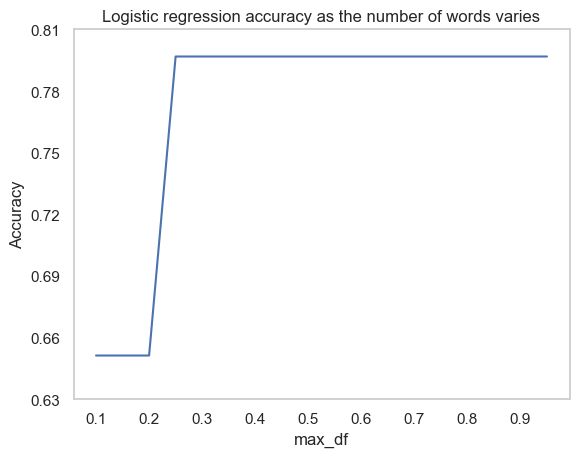

In [37]:
x=np.arange(0.1,1.0,0.05)
plt.plot(x, results_list)
plt.xlabel("max_df")
plt.ylabel("Accuracy")
plt.xticks(np.arange(0.1, 1, 0.1))
plt.yticks(np.arange(0.63, 0.83, 0.03))
plt.title("Logistic regression accuracy as the number of words varies")
plt.grid()

In [38]:
pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = 0.25, min_df = 0.0012)),
        ('clf', LogisticRegression())
    ])
print("Shape max_df = 0.25")
X_vector = pipeline['tfidf'].fit_transform(complete_train)
print(X_vector.shape)
pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = 0.3, min_df = 0.0012)),
        ('clf', LogisticRegression())
    ])
print("Shape max_df = 0.3")
X_vector = pipeline['tfidf'].fit_transform(complete_train)
print(X_vector.shape)

Shape max_df = 0.25
(20450, 1412)
Shape max_df = 0.3
(20450, 1412)


As we observed, we haven't word with a frequency greater than 25%

In [39]:
results_list=[]
for max_df in np.arange(0.20,0.22,0.002):
    pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = max_df, min_df = 0.0012)),
        ('clf', LogisticRegression())
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

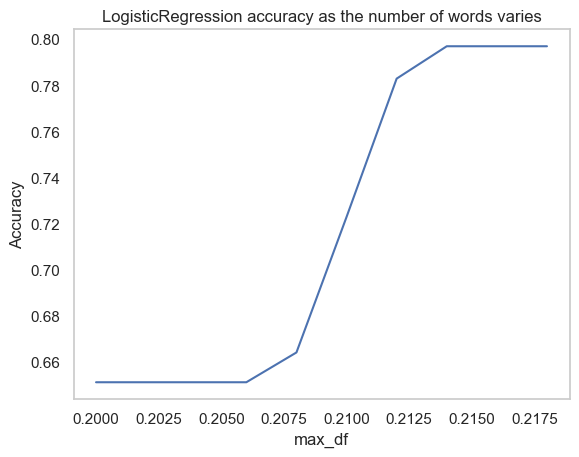

In [40]:
x=np.arange(0.20,0.22,0.002)
plt.plot(x, results_list)
plt.xlabel("max_df")
plt.ylabel("Accuracy")
plt.title("LogisticRegression accuracy as the number of words varies")
plt.grid()

Since the differencies is very high, we put max_df = 0.2126 (we can also take higher values since there not token with an higher frequency than 21,6%)

## Stemming or not stemming

In [41]:
from nltk.stem.snowball import SnowballStemmer
results_list = []
snow_stemmer = SnowballStemmer('english')
def snowball_analyzer(doc):
    return [snow_stemmer.stem(w) for w in analyzer(doc)]

#without stemming
pipeline_ns = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', LogisticRegression()),
])
results=cross_val_score(pipeline_ns, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

#with stemming
analyzer = pipeline_ns['tfidf'].build_analyzer()

pipeline_s = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = snowball_analyzer)),
    ('clf', LogisticRegression()),
])
results=cross_val_score(pipeline_s, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

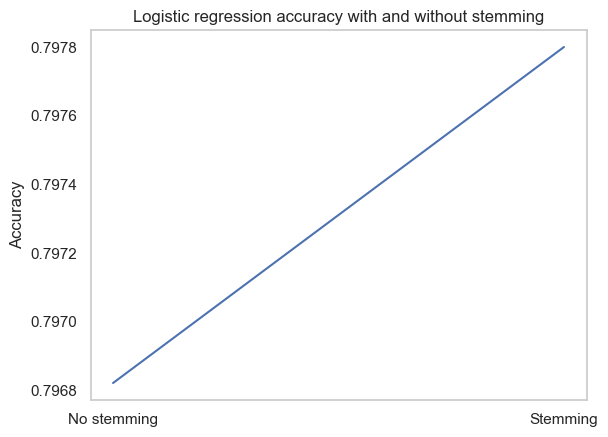

In [42]:
x=["No stemming", "Stemming"]
plt.plot(x, results_list)
plt.ylabel("Accuracy")
plt.title("Logistic regression accuracy with and without stemming")
plt.grid()

In [43]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
accuracies_ns = custom_accuracy_validation(pipeline_ns, skf,complete_train.to_numpy(),complete_class_train.to_numpy())
accuracies_s = custom_accuracy_validation(pipeline_s, skf,complete_train.to_numpy(),complete_class_train.to_numpy())
print(wilcoxon(accuracies_s, accuracies_ns))  #α = 0.05

WilcoxonResult(statistic=18.0, pvalue=0.375)


Given the confidence level α=0.05, we can conclude that as *p*-value > α, the null hypothesis (that the two related paired samples come from the same distribution) cannot be rejected.

We can conclude that there is not significant difference between the two classification pipelines in terms of the chosen classification metric (accuracy).

The classification pipeline without stemming can be regarded as the most suitable one.

# Function used to evaluate the results of cross validation

In [28]:
from sklearn.metrics import accuracy_score, classification_report
def eval_cross_validation(pipeline, skf, X, y):
    list_df = []
    list_accuracy = []

    k = 1
    for train, val in skf.split(X, y):
        # fit and predict using pipeline
        X_tr = X[train]
        y_tr = y[train]
        X_val = X[val]
        y_val = y[val]
        pipeline.fit(X_tr,y_tr)
        y_pred = pipeline.predict(X_val)
        # compute classification report
        cr = classification_report(y_val,y_pred,output_dict = True)
        # store accuracy
        list_accuracy.append(cr['accuracy'])
        # store per-class metrics as a dataframe
        df = pd.DataFrame({k:v for k,v in cr.items() if k!='accuracy'})
        list_df.append(df)
        k+=1


    # compute average per-class metrics    
    df_concat = pd.concat(list_df)
    grouped_by_row_index = df_concat.groupby(df_concat.index)
    df_avg = grouped_by_row_index.mean()
    
    # compute average accuracy
    accuracy_avg = np.mean(list_accuracy)
    
    #save the f1-score values
    f_values = df_concat.loc["f1-score"]['macro avg'].to_numpy()
    
    return df_avg, accuracy_avg, f_values 

# REPLICA OF MODEL USED IN THE PAPER

## Logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', LogisticRegression()),
])

In [30]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
df_lg, acc_lg, f_values_lg = eval_cross_validation(pipeline, skf, complete_train.to_numpy(),complete_class_train.to_numpy())

In [31]:
df_lg

,bot,human,macro avg,weighted avg
f1-score,0.818273,0.787281,0.802777,0.802834
precision,0.765353,0.856844,0.811099,0.810933
recall,0.879165,0.728307,0.803736,0.804010
support,1026.200000,1018.800000,2045.000000,2045.000000


In [32]:
acc_lg

0.8040097799511002

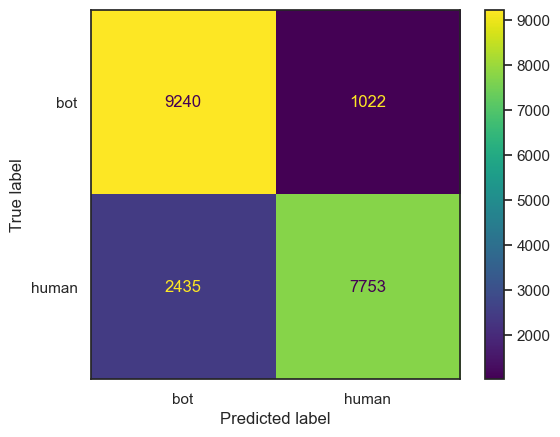

In [33]:
sns.set_theme(style="white")
ConfusionMatrixDisplay.from_estimator(pipeline,complete_train.to_numpy(),complete_class_train.to_numpy())

## Analysis of prediction results on test-set 

              precision    recall  f1-score   support

       human       0.75      0.87      0.81      2522
         bot       0.85      0.71      0.78      2591

    accuracy                           0.79      5113
   macro avg       0.80      0.79      0.79      5113
weighted avg       0.80      0.79      0.79      5113



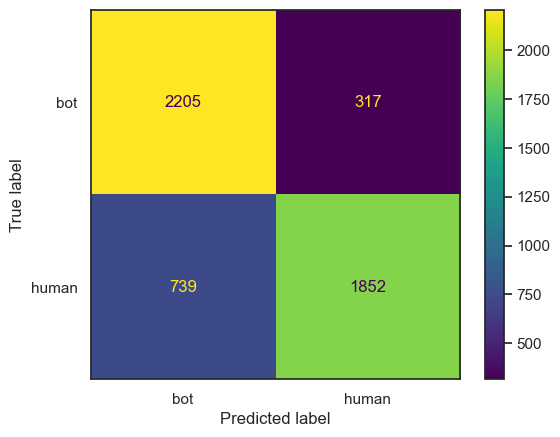

In [34]:
y_pred = pipeline.predict(complete_test)
print(classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique()))
ConfusionMatrixDisplay.from_predictions(complete_class_test,y_pred)

# SVC

In [35]:
from sklearn.svm import SVC
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', SVC(kernel='linear')),
])

In [36]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
df_svc, acc_svc, f_values_svc = eval_cross_validation(pipeline, skf, complete_train.to_numpy(),complete_class_train.to_numpy())

In [37]:
df_svc

,bot,human,macro avg,weighted avg
f1-score,0.823505,0.790103,0.806804,0.806864
precision,0.765353,0.868899,0.817126,0.816938
recall,0.891345,0.724578,0.807961,0.808264
support,1026.200000,1018.800000,2045.000000,2045.000000


In [38]:
acc_svc

0.8082640586797065

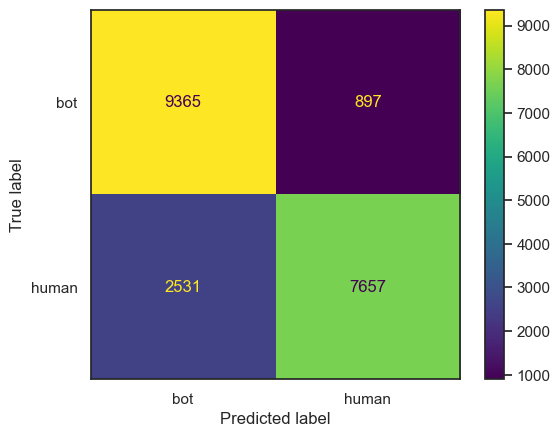

In [39]:
ConfusionMatrixDisplay.from_estimator(pipeline,complete_train.to_numpy(),complete_class_train.to_numpy())

## Analysis of prediction results on test-set 

              precision    recall  f1-score   support

       human       0.75      0.88      0.81      2522
         bot       0.86      0.71      0.78      2591

    accuracy                           0.80      5113
   macro avg       0.81      0.80      0.79      5113
weighted avg       0.81      0.80      0.79      5113



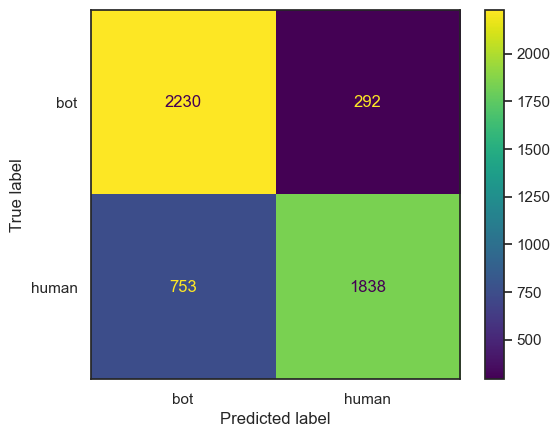

In [40]:
y_pred = pipeline.predict(complete_test)
print(classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique()))
ConfusionMatrixDisplay.from_predictions(complete_class_test,y_pred)

# Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(max_depth=30, min_samples_leaf=2, min_samples_split=15, n_estimators=500)),
])

In [42]:
df_rf, acc_rf, f_values_rf = eval_cross_validation(pipeline, skf, complete_train.to_numpy(),complete_class_train.to_numpy())

In [43]:
df_rf

,bot,human,macro avg,weighted avg
f1-score,0.827422,0.779659,0.803541,0.803627
precision,0.748859,0.900423,0.824641,0.824367
recall,0.924479,0.687574,0.806026,0.806455
support,1026.200000,1018.800000,2045.000000,2045.000000


In [44]:
acc_rf

0.8064547677261615

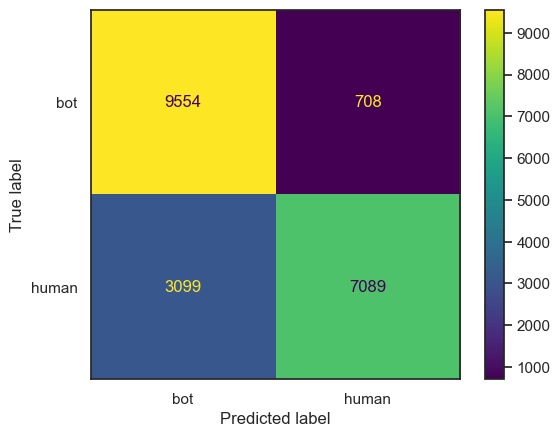

In [45]:
ConfusionMatrixDisplay.from_estimator(pipeline,complete_train.to_numpy(),complete_class_train.to_numpy())

## Analysis of prediction results on test-set

              precision    recall  f1-score   support

       human       0.74      0.93      0.82      2522
         bot       0.91      0.67      0.77      2591

    accuracy                           0.80      5113
   macro avg       0.82      0.80      0.80      5113
weighted avg       0.82      0.80      0.80      5113



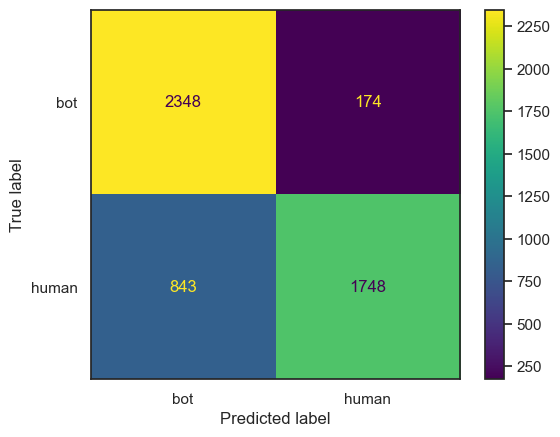

In [46]:
y_pred = pipeline.predict(complete_test)
print(classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique()))
ConfusionMatrixDisplay.from_predictions(complete_class_test,y_pred)

# Are the parameters chosen, the bests available?

# Logistic Regression

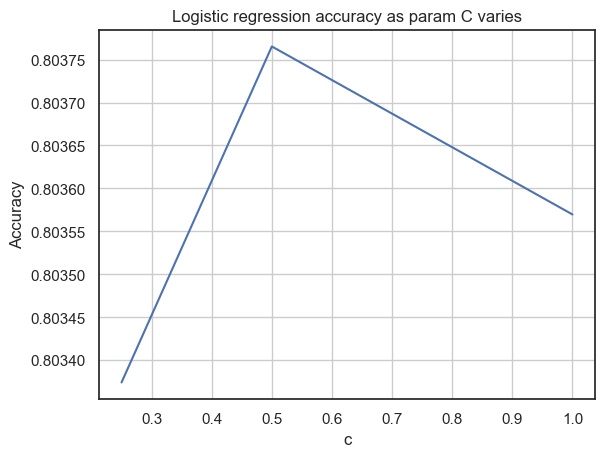

In [47]:
results_list=[]

for c in [0.25, 0.5]:
    pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = 0.22, min_df = 0.0012)),
        ('clf', LogisticRegression(C=c))
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

pipeline=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = 0.22, min_df = 0.0012)),
        ('clf', LogisticRegression())
    ])
results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                        cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

x=[0.25, 0.5, 1]
plt.plot(x, results_list)
plt.xlabel("c")
plt.ylabel("Accuracy")
plt.title("Logistic regression accuracy as param C varies")
plt.grid()

Since the accuracy difference between having c = 1 and having c = 0.5 is about 0.2%, we choose the simplest model, i.e the model with c=1.0 <br>
Even TweepFake research choose this value

# SVC 

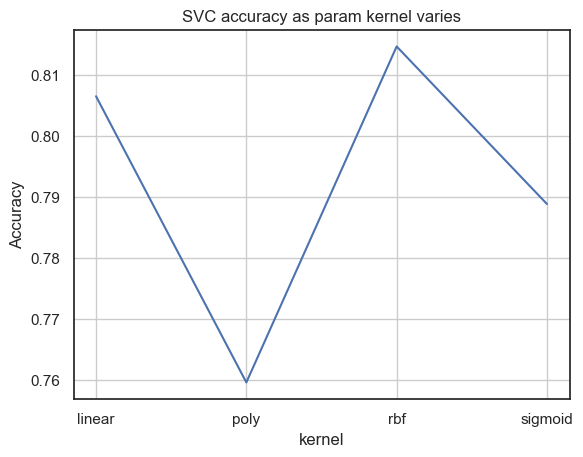

In [48]:
results_list = []
for kernel in ['linear','poly','rbf','sigmoid']:
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', SVC(kernel = kernel)),
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

    
x=['linear','poly','rbf','sigmoid']
plt.plot(x, results_list)
plt.xlabel("kernel")
plt.ylabel("Accuracy")
plt.title("SVC accuracy as param kernel varies")
plt.grid()

In [49]:
# linear
linear = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', SVC(kernel = "linear")),
    ])
a_l=cross_val_score(linear, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)

# rbf
rbf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', SVC(kernel = "rbf")),
    ])
a_rbf=cross_val_score(rbf, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)

wilcoxon(a_rbf, a_l)

WilcoxonResult(statistic=0.0, pvalue=0.0625)

Given the confidence level α=0.05, we can conclude that as *p*-value > α, the null hypothesis (that the two related paired samples come from the same distribution) cannot be rejected. <br>
So we choose linear as kernel function.

# Random Forests
Since we have several parameters to test, we test them one by one, in order to plot how the accuracy changes

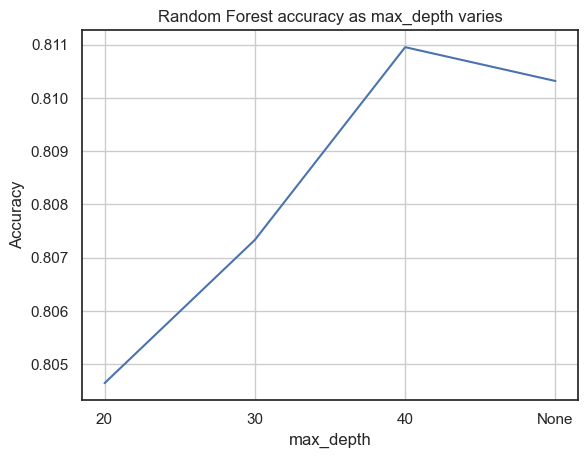

In [50]:
results_list = []
for max_depth in range(20,50,10):
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(max_depth= max_depth)),
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(max_depth= None)),
    ])
results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                        cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
results_list.append(np.mean(results))

x=['20','30','40','None']
plt.plot(x, results_list)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title("Random Forest accuracy as max_depth varies")
plt.grid()

Since differences in the accuracy value, for all the classifier are about 1%, the differences between 30 and None as max_depth is important for us, because we pass from around 80% to around 81%. Is that due to the chance? We need to perform a Wilcoxon test between the two models


In [52]:
# max_depth = 30
rf30 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.25, min_df=0.0012)),
    ('clf', RandomForestClassifier(max_depth=30)),
])
a_30=cross_val_score(rf30, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)

# max_depth = None
rfn = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.25, min_df=0.0012)),
    ('clf', RandomForestClassifier(max_depth=None)),
])
a_n=cross_val_score(rfn, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)

wilcoxon(a_30, a_n)

WilcoxonResult(statistic=4.0, pvalue=0.4375)

Given the confidence level α=0.05, we can conclude that as *p*-value > α, the null hypothesis (that the two related paired samples come from the same distribution) cannot be rejected.

We can conclude that there is no significant difference between the two classification pipelines in terms of the chosen classification metric (f1-score).

The classification pipeline with max_depth = 30 can be regarded as the most suitable one: the improvement brought by not limit the tree depth is not-significant, thus the simplest classification pipeline should be chosen.

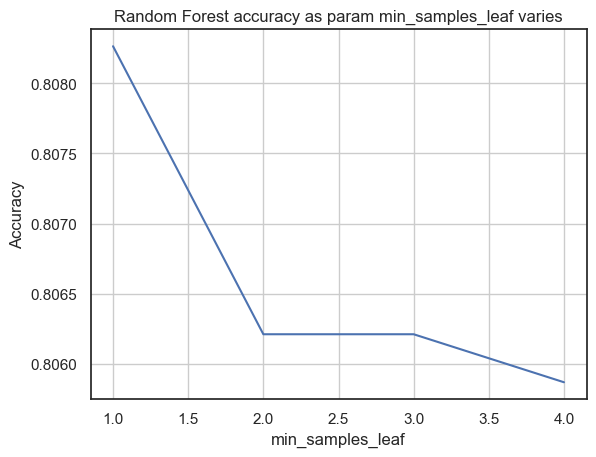

In [53]:
results_list = []
for m in [1,2,3,4]:
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=m, max_depth=30)),
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

x=[1,2,3,4]
plt.plot(x, results_list)
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title("Random Forest accuracy as param min_samples_leaf varies")
plt.grid()

Since differences in accuracy are very low, we choose directly the simplest model, i.e. the one with min_samples_leaf=4

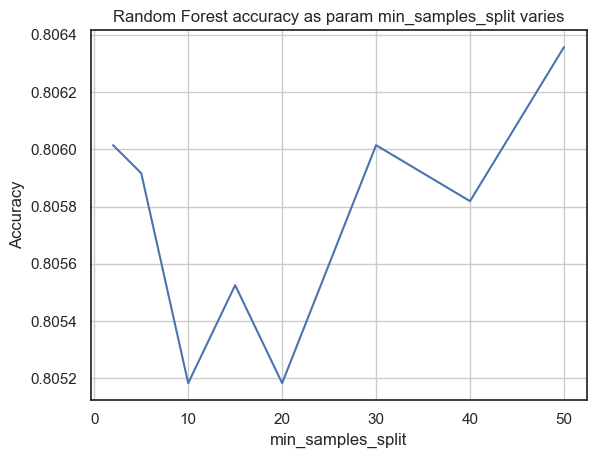

In [54]:
results_list = []
for m in [2,5,10,15,20,30,40,50]:
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= m)),
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

x=[2,5,10,15,20,30,40,50]
plt.plot(x, results_list)
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.title("Random Forest accuracy as param min_samples_split varies")
plt.grid()

In [56]:
# min_samples_split = 5
rf10 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 10))
])
a_10=cross_val_score(rf10, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
# min_samples_split = 50
rf50 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50))
])
a_50=cross_val_score(rf50, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
wilcoxon(a_50, a_10)

C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\david\anaconda3\envs\DMML\lib\site-packages\scipy\stats\_morestats.py:3269: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=4.0, pvalue=0.7150006546880893)

Given the confidence level α=0.05, we can conclude that as *p*-value > α, the null hypothesis (that the two related paired samples come from the same distribution) cannot be rejected.

We can conclude that there is no significant difference between the two classification pipelines in terms of the chosen classification metric (accuracy).

The classification pipeline with min_samples_split = 50 can be regarded as the most suitable one: the improvement brought by min_samples_split = 10 is not-significant, thus the simplest classification pipeline should be chosen.


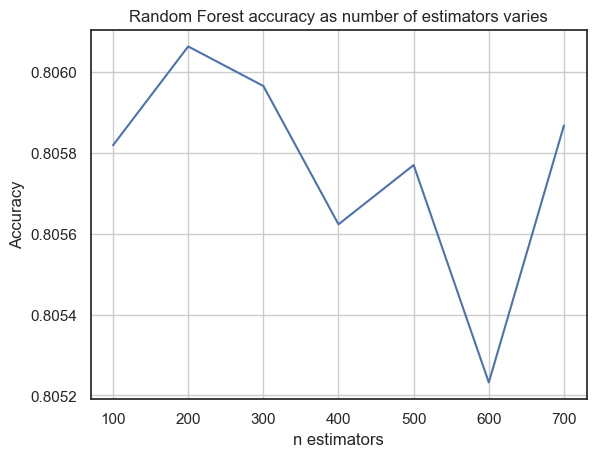

In [57]:
results_list = []
for n in range(100,800,100):
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators = n)),
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

x= range(100,800,100)
plt.plot(x, results_list)
plt.xlabel("n estimators")
plt.ylabel("Accuracy")
plt.title("Random Forest accuracy as number of estimators varies")
plt.grid()

In [58]:
# 100 estimators
rf5 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators=100))
])
a_5=cross_val_score(rf5, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
# 400 estimators
rf50 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.00012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators=400))
])
a_50=cross_val_score(rf50, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
wilcoxon(a_5, a_50)

WilcoxonResult(statistic=0.0, pvalue=0.0625)

We choose the simplest model, with 100 estimators

# Parameters choice
We choose parameter based on the result of the Wilcoxon test. Sometimes it isn't performed because irrivelant, since the differences between the two values of confidence is very low, we directly choose the simplest model.

Differences between our model and TweepFake model: <br>
our --> RandomForestClassifier(<b>min_samples_leaf=4</b>, max_depth=30, <b> min_samples_split= 50, n_estimators = 100 </b>)) <br>
TweepFake --> RandomForestClassifier(<b>min_samples_leaf=2</b>, max_depth=30, <b> min_samples_split= 15, n_estimators = 500 </b>)) 

In [59]:
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators = 100)),
    ])
df_rf, acc_rf, f_values_rf = eval_cross_validation(pipeline, skf, complete_train.to_numpy(),complete_class_train.to_numpy())

In [60]:
df_rf

,bot,human,macro avg,weighted avg
f1-score,0.826791,0.779169,0.802980,0.803066
precision,0.748652,0.898929,0.823791,0.823518
recall,0.923211,0.687672,0.805442,0.805868
support,1026.200000,1018.800000,2045.000000,2045.000000


In [61]:
acc_rf

0.8058679706601467

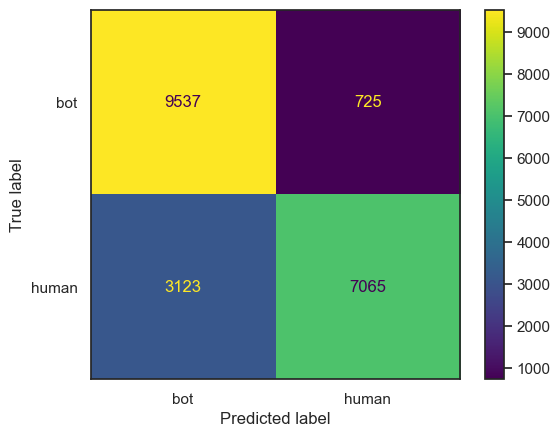

In [62]:
ConfusionMatrixDisplay.from_estimator(pipeline,complete_train.to_numpy(),complete_class_train.to_numpy())

              precision    recall  f1-score   support

       human       0.74      0.93      0.82      2522
         bot       0.91      0.68      0.77      2591

    accuracy                           0.80      5113
   macro avg       0.82      0.80      0.80      5113
weighted avg       0.82      0.80      0.80      5113



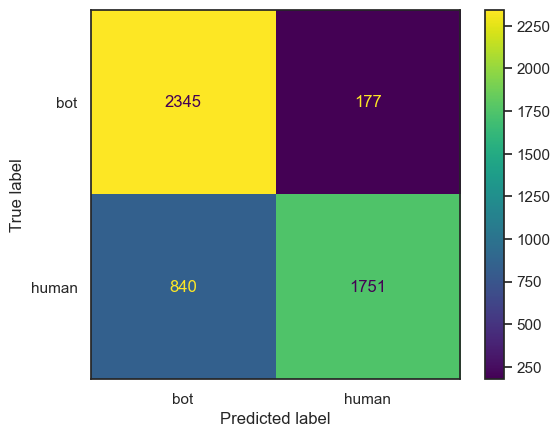

In [63]:
y_pred = pipeline.predict(complete_test)
print(classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique()))
ConfusionMatrixDisplay.from_predictions(complete_class_test,y_pred)

**Our model is simpler and obtain the same results**

# Try to use new classifier

## Multinomial NB

In [64]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', MultinomialNB()),
])
df_mn, acc_mn, f_values_mn = eval_cross_validation(pipeline, skf, complete_train.to_numpy(),complete_class_train.to_numpy())


In [65]:
df_mn

,bot,human,macro avg,weighted avg
f1-score,0.699546,0.735772,0.717659,0.717594
precision,0.754051,0.692136,0.723093,0.723205
recall,0.652698,0.785532,0.719115,0.718875
support,1026.200000,1018.800000,2045.000000,2045.000000


In [66]:
acc_mn

0.7188753056234718

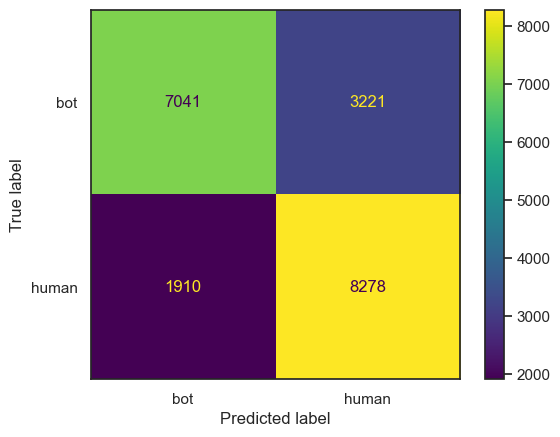

In [67]:
ConfusionMatrixDisplay.from_estimator(pipeline,complete_train.to_numpy(),complete_class_train.to_numpy())

## Analysis of prediction results on test-set 

              precision    recall  f1-score   support

       human       0.75      0.67      0.71      2522
         bot       0.71      0.79      0.74      2591

    accuracy                           0.73      5113
   macro avg       0.73      0.73      0.73      5113
weighted avg       0.73      0.73      0.73      5113



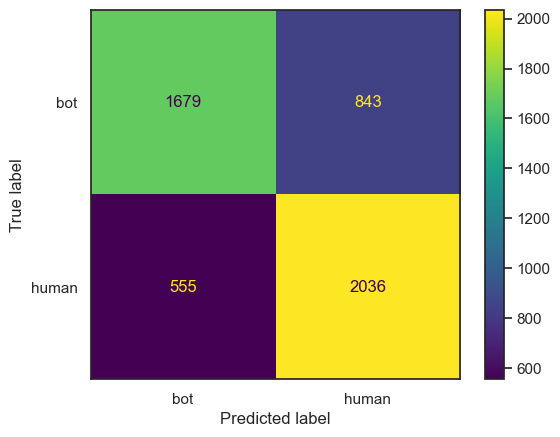

In [68]:
y_pred = pipeline.predict(complete_test)
print(classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique()))
ConfusionMatrixDisplay.from_predictions(complete_class_test,y_pred)

# Adaboost

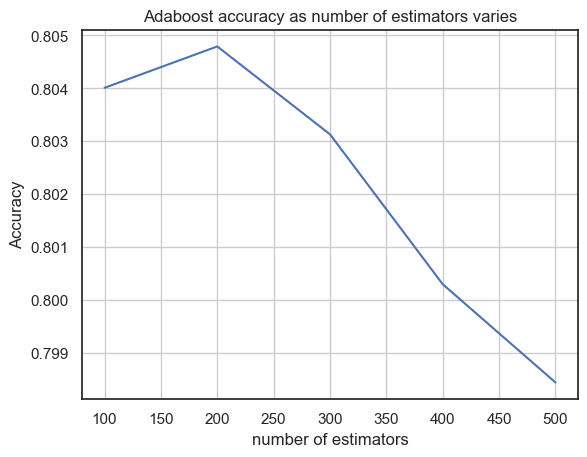

In [69]:
from sklearn.ensemble import AdaBoostClassifier
results_list = []
for n in range(100,600,100):
    pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', AdaBoostClassifier(n_estimators=n)),
    ])
    results=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)
    results_list.append(np.mean(results))

x=range(100,600,100)
plt.plot(x, results_list)
plt.xlabel("number of estimators")
plt.ylabel("Accuracy")
plt.title("Adaboost accuracy as number of estimators varies")
plt.grid()

In [70]:
# 100
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', AdaBoostClassifier(n_estimators=100)),
])
f100=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)

# 200
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', AdaBoostClassifier(n_estimators=200)),
])
f200=cross_val_score(pipeline, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(5, shuffle=True, random_state=123),n_jobs=-1)

wilcoxon(f100, f200)

WilcoxonResult(statistic=5.0, pvalue=0.625)

We choose as classifier the simplest, i.e. estimator=100

In [71]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', AdaBoostClassifier(n_estimators=100)),
])
df_ab, acc_ab, f_values_ab = eval_cross_validation(pipeline, skf, complete_train.to_numpy(),complete_class_train.to_numpy())

In [72]:
df_ab

,bot,human,macro avg,weighted avg
f1-score,0.822353,0.788693,0.805523,0.805584
precision,0.764206,0.867411,0.815809,0.815622
recall,0.890177,0.723204,0.806691,0.806993
support,1026.200000,1018.800000,2045.000000,2045.000000


In [73]:
acc_ab

0.8069926650366748

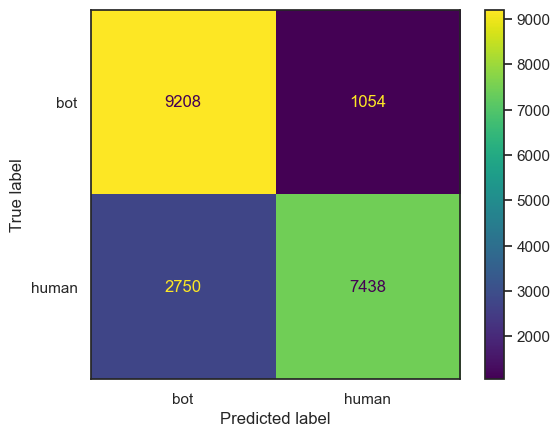

In [74]:
ConfusionMatrixDisplay.from_estimator(pipeline,complete_train.to_numpy(),complete_class_train.to_numpy())

## Analysis of prediction results on test-set

              precision    recall  f1-score   support

       human       0.76      0.89      0.82      2522
         bot       0.87      0.72      0.79      2591

    accuracy                           0.80      5113
   macro avg       0.81      0.80      0.80      5113
weighted avg       0.81      0.80      0.80      5113



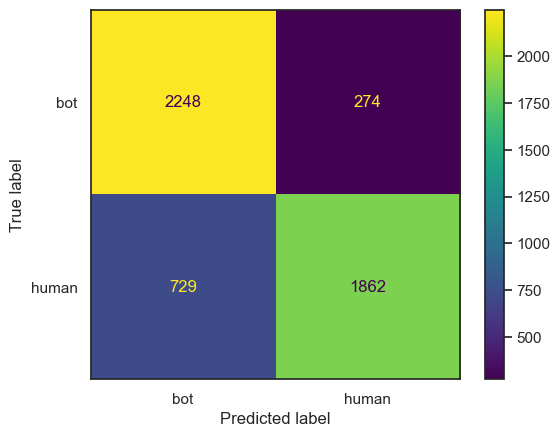

In [75]:
y_pred = pipeline.predict(complete_test)
print(classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique()))
ConfusionMatrixDisplay.from_predictions(complete_class_test,y_pred)

# Classifier choice

In [76]:
classifier = ["Log regression","Random Forest", "SVC", "MultinomialNB", "Adaboost"]
accuracy_on_test = []
f1_on_test = []
lg=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = 0.22, min_df = 0.0012)),
        ('clf', LogisticRegression(C=1))
    ])
lg.fit(complete_train,complete_class_train)
y_pred = lg.predict(complete_test)
lg_report = classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique(), output_dict=True)
accuracy_on_test.append(lg_report['accuracy'])
f1_on_test.append(lg_report['macro avg']['f1-score'])

rf=Pipeline([
        ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df = 0.22, min_df = 0.0012)),
        ('clf', RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators = 100))
    ])
rf.fit(complete_train,complete_class_train)
y_pred = rf.predict(complete_test)
rf_report = classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique(), output_dict=True)
accuracy_on_test.append(rf_report['accuracy'])
f1_on_test.append(rf_report['macro avg']['f1-score'])

svc = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', SVC(kernel = "linear")),
    ])
svc.fit(complete_train,complete_class_train)
y_pred = svc.predict(complete_test)
svc_report = classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique(), output_dict=True)
accuracy_on_test.append(svc_report['accuracy'])
f1_on_test.append(svc_report['macro avg']['f1-score'])

mn = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', MultinomialNB()),
])
mn.fit(complete_train,complete_class_train)
y_pred = mn.predict(complete_test)
mn_report = classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique(), output_dict=True)
accuracy_on_test.append(mn_report['accuracy'])
f1_on_test.append(mn_report['macro avg']['f1-score'])

ab = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', AdaBoostClassifier(n_estimators=100)),
])
ab.fit(complete_train,complete_class_train)
y_pred = ab.predict(complete_test)
ab_report = classification_report(complete_class_test,y_pred,target_names = complete_class_test.unique(), output_dict=True)
accuracy_on_test.append(ab_report['accuracy'])
f1_on_test.append(ab_report['macro avg']['f1-score'])

In [77]:
classifier_results = pd.DataFrame(list(zip(classifier, accuracy_on_test,f1_on_test)),columns=['Classifier', 'Accuracy', 'f1-score'])
classifier_results = classifier_results.set_index('Classifier')
classifier_results

,Accuracy,f1-score
Classifier,,
Log regression,0.796988,0.796123
Random Forest,0.801682,0.799015
SVC,0.800313,0.798969
MultinomialNB,0.725797,0.724557
Adaboost,0.803833,0.802423


The only model we can discard is the MultinomialNB one, since Accuracy and f1-score are very different from other classifier.

To choose one classifier we'll perform the Wilcoxon test.

In [80]:
accuracies_rf = cross_val_score(rf, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
accuracies_lg = cross_val_score(lg, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
wilcoxon(accuracies_lg,accuracies_rf)

WilcoxonResult(statistic=14.0, pvalue=0.193359375)

There's no differences between classifier since we choose alpha = 0.05.

In [82]:
accuracies_ab = cross_val_score(ab, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
wilcoxon(accuracies_lg,accuracies_ab)

WilcoxonResult(statistic=24.0, pvalue=0.76953125)

There's no differences between classifier since we choose alpha = 0.05.

In [83]:
accuracies_svc = cross_val_score(svc, complete_train.to_numpy(),complete_class_train.to_numpy(), 
                            cv=KFold(10, shuffle=True, random_state=123),n_jobs=-1)
wilcoxon(accuracies_svc,accuracies_lg)

WilcoxonResult(statistic=11.0, pvalue=0.10546875)

## If we use an ensamble method with RFF and SVC and Adaboost, does the accuracy improve?

In [183]:
from sklearn.ensemble import VotingClassifier
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
clf1 = AdaBoostClassifier(n_estimators=100)
clf2 = SVC(kernel = "linear")
clf3 = RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators = 100)

eclf = VotingClassifier(estimators=[('ab', clf1), ('svc', clf2), ('rf', clf3)], voting='hard')

ensamble_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', eclf),
])
df_e, acc_e, f_values_e = eval_cross_validation(ensamble_pipeline, skf, final_dataset.Tweet.to_numpy(),final_dataset.Account_type.to_numpy())
df_e

,bot,human,macro avg,weighted avg
f1-score,0.791802,0.682580,0.737191,0.737202
precision,0.675690,0.924961,0.800326,0.800301
recall,0.956117,0.540888,0.748502,0.748543
support,1278.400000,1277.900000,2556.300000,2556.300000


In [184]:
acc_e

0.7485434748149087

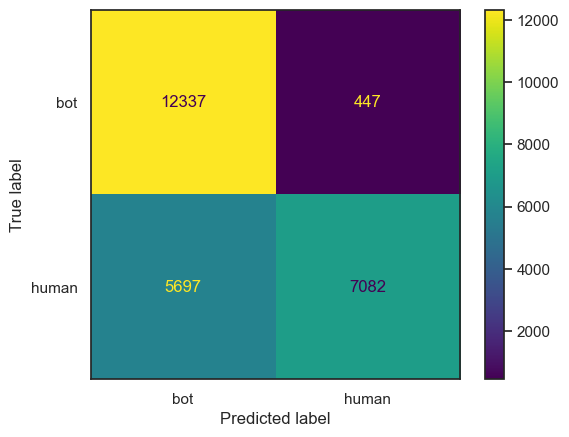

In [185]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(ensamble_pipeline,final_dataset.Tweet.to_numpy(),final_dataset.Account_type.to_numpy())

We obtain worse results, maybe using an ensamble method with different classifiers we can do better?

In [186]:
from sklearn.ensemble import VotingClassifier
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 123)
clf1 = LogisticRegression(C=1)
clf2 = SVC(kernel = "linear")
clf3 = RandomForestClassifier(min_samples_leaf=4, max_depth=30, min_samples_split= 50, n_estimators = 100)

eclf2 = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('rf', clf3)], voting='hard')

ensamble_pipeline2 = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords, max_df=0.22, min_df=0.0012)),
    ('clf', eclf2),
])
df_e2, acc_e2, f_values_e2 = eval_cross_validation(ensamble_pipeline2, skf, final_dataset.Tweet.to_numpy(),final_dataset.Account_type.to_numpy())
df_e2

,bot,human,macro avg,weighted avg
f1-score,0.783630,0.715813,0.749721,0.749728
precision,0.700352,0.848520,0.774436,0.774422
recall,0.889473,0.619142,0.754307,0.754333
support,1278.400000,1277.900000,2556.300000,2556.300000


In [187]:
acc_e2

0.754333114228761

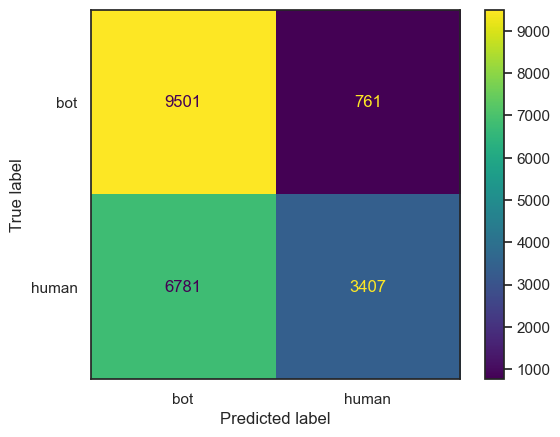

In [188]:
ConfusionMatrixDisplay.from_estimator(ensamble_pipeline2,final_dataset.Tweet.to_numpy(),final_dataset.Account_type.to_numpy())

# We choose as classificator **Logistic regression** because it is the simplest model